In [3]:
def create_md_of_notebook():
    !jupyter nbconvert ./chpt3_classification.ipynb --to markdown

# Classifying the MNIST dataset - the "Hello, World!" of ML

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## MNIST
The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the "hello world" of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of the. The following code fetches the MNIST dataset.

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following
- A `DESCR` keyword describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
- A `target` key containing an array with the labels

Let's look at these arrays

In [6]:
X, y = mnist["data"].to_numpy(), mnist["target"].to_numpy()
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a look at one digit from the dataset. All you need to do is grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's `imshow()` function:

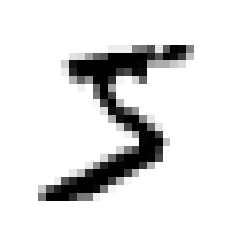

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that's what the label tells us:

In [8]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let's cast `y` to integer:

In [9]:
y = y.astype(np.uint8)

You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

The training set is already shuffled for us, which is good because this guarentees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit - for example, the number 5. This "5-detector" will be an example of a _binary classifier_, capable of distinguishing betrween just two classes, 5 and not-5. Let's create the target vectors for this classification task:

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let's pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent_ (SGD) classifier, using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning). Let's create an `SGDClassifier` and train it on the whole training set:

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

>The `SGDClassifier` relies on randomness during training (hence the name "stochastic"). If you want reproducible results, you should set the `random_state` parameter.

Now we can use it to detect images of the number 5:

In [13]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case. Now, let's evaluate the model's performance.

## Performance Measures
### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation.

#### Aside - Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function, and it prints the same result.

The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy (ratio of correct predictions) on all cross-validatin folds? This looks really good, but first let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This model's accuracy has over 90%. This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preffered performance measure for classifiers, especially when you are dealing with _skewed datasets_ (i.e., when some classes are much more frequent than others).

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the _confusion matrix_. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s and 3s, you would look in the fifth row and third column of the confusion matrix

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch, so we can use the `cross_val_predict()` function.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns, the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target class (`y_train_5`) and the predicted classes (`y_train_pred`):

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an _actual class_, while each column represents a _predicted class_. The first row of this matrix considers non-5 images (the _negative class_): 53,892 of them were correctly classified as non-5s (they are called _true negatives_), while the remaining 687 were classified as 5s (_false positives_). The second row considers the images of 5s (the _positive class_): 1,891 were wrongly classified as non-5s (_false negatives_), while the remaining 3,530 were correctly classified as 5s (_true positives_). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [19]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the _precision_ of the classifier:

$$ precision = {TP \over TP+FP} $$

$TP$ is the number of true positives, and $FP$ is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named _recall_, also called _sensitivity_ or the _true positive rate_ (TPR): this is the ratio of positive instances that are correctly detected by the classifier:

$$ recall = {TP \over TP+FN} $$

where $FN$ is the number of false negatives.


#### Precision and Recall
Scikit-learn provides several functions to compute classifier metrics, including precision and recall

In [20]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


Now the classifier doesn't look as good as when you only looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_1$ score, in particular if you need a simple way to compare two classifiers. The $F_1$ score is the _harmonic mean_ of precision and recall (see below). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.


$$ F_1 = {2 \over {1 \over precision} + {1 \over recall}} = {2 * {{precision * recall} \over {precision + recall}}} = {TP \over {TP + {FN + FP \over 2}}}$$

To compute the $F_1$ score, simply call the `f1_score()` function:

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favours classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product. On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will geta  few false alarts, but almost all shoplifters will get caught).

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the _precision/recall trade-off_.

#### Precision/Recall Trade-off

To understand this trade-off, let's look at how the `SGDClassifier` makes its classification decision. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold, it assugns the instance to the positive class; otherwise it assigns it to the negative class. Suppose you have six actual 5s to detect and a _decision threshold_ that results in 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (i.e., move the threshold further to the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases the recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier;s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method (i.e., `True`). Let's raise the threshold:

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value.

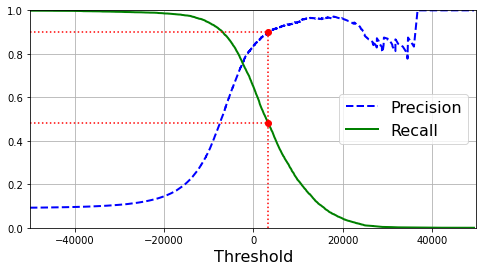

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall, shown below (the same threshold as earlier is highlighted).

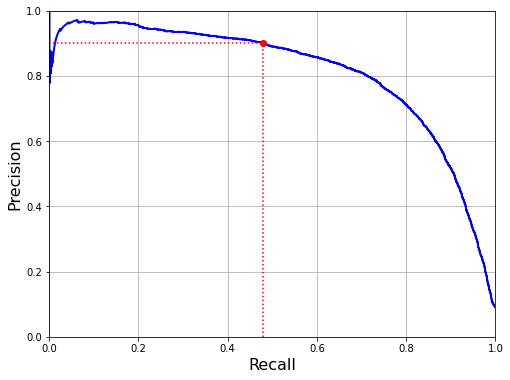

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off before that drop - for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (`np.argmax()` will give you the first index of the maximum value, which in this case means the first `True` value):

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, you can run this code:

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let's check these predictions' precision and recall

In [30]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


Now we have a 90% precision classifier! As you can see, it's fairly easy to create a classifier with cirtually any precision you want: just set a high enough threshold, and you're done. However, a high-precision classifier is not very useful if its recall is too low.

#### The ROC Curve

The _receiver operating characteristic_ (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the _the true negative rate_ (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. Hence, the ROC curve plots _sensitivity_ (recall) versus 1 - _specificity.

The plot the ROC curve, you first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:


In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib, shown below:

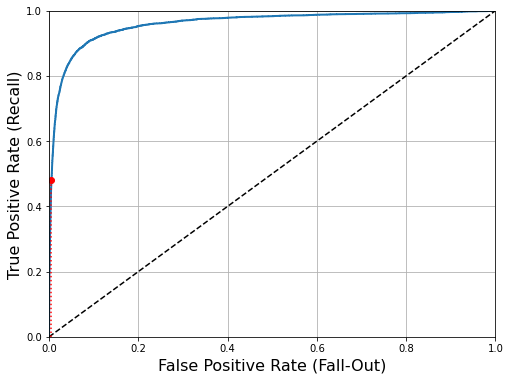

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards the top-left corner).

One way to compare classifiers is to measyre the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

Let's now train a `RandomForestClassifiers` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`. First, you need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` class does not have a `decision_function()` method. Instead, it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other, or both. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

The `roc_curve()` function expects labels and scores, but instead of scores you can give it probabilities. Let's use the positive class's probability as he score:

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare:

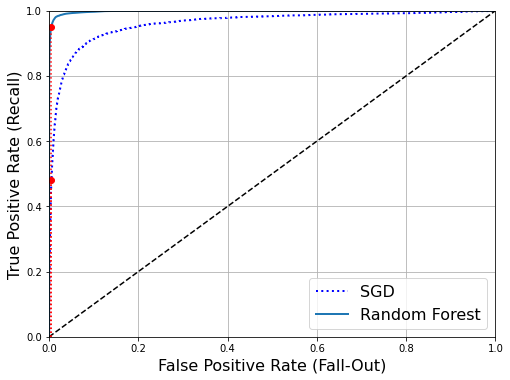

In [37]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

As you can see, the `RandomForestClassifier`'s ROC curve looks much better than the `SGDClassifier`'s: it comes much claser to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

We can also check the prevision and recall scores:

In [39]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))


0.9905083315756169
0.8662608374838591


We now know how to trained a binary classifier, choose the appropriate metric for the task, evaluate the classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now we will try to detect more than just the 5s.

### Multiclass Classification

Whereas binary classifiers distinguish between two classes, _multiclass classifiers_ (also called _multinomial classifiers_) can distinguish between more than two classes.

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you canuse to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, etc.). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the _one-versus-the-rest_ (OvR) strategy (also called _one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, etc.. This is called the _one-versus-one_ (OvO) strategy. If there are _N_ classes, you need to train $N * (N - 1) \over 2$ classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that is must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.




Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let's try this with a Support Vector Machine classifier using the `sklearn.svm.SVC` class:

In [40]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the `SVC` on the training set using the original target classes from 0 to 9 (`y_train`), instead of the 5-versus-the-rest target classes (`y_train_5`). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the `decision_function()` method, you will see that it returns 10 scores per instance (instead of just 1). That's one score per class:

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score is indeed the one corresponding to class 5:

In [42]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


> When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In this case, the index of each class in the `classes_` array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won't be so lucky.

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the `OnveVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an `SVC`:

In [43]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


Training an `SGDClassifier` (or a `RandomForestClassifier`) is just as easy:

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time Scikit-learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. The `decision_function()` method now returns one value per class. Let's look at the score that the SGD classifier assigned to each class:

In [45]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a high score. The model has a slight doubt regarding class 3. Now of course you want to evaluate this classifier. As usual, you can use cross-validation. Use the `cross_val_score()` function to evaluate the `SGDClassifier`'s accuracy:

In [ ]:
# Warning: This cell may take close to 30 minutes to run, or more depending on your hardware.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs increases accuracy above 89%.

In [ ]:
# Warning: This cell may take close to 30 minutes to run, or more depending on your hardware.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### Error Analysis
If this were a real project, you would have followed these steps:

1. You'd eplore data preparation options
2. Try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters using `GridSearcgCV`)
3. Automate as much as possible

Here, we will assume you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` functions, just like you did earlier:

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

NameError: name 'X_train_scaled' is not defined